# Feature Selection and Random Forest

In [36]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC

from matplotlib import pyplot as plt

### Read the file and minor data processing
The file is read in this column and some minor data processing has applied. In the Rolename column, it contains 2 types of string data, Mentor and Player, indicating the role of the character in the Virtual Internship. Given that the goal of the project is to predict the Player's final OutcomeScore, all the rows with Mentor will have to be removed.

In [37]:
df = pd.read_csv("../data/data.csv")
df = df[df["RoleName"] != "Mentor"]

x is the content, which is the text data that are recorded during the Virtual Internship project, provided by what the Player said in the conversation.
Y is the outcome score, which is the final score that the model will try to predict.

In [38]:
x = df['content']
y = df['OutcomeScore']

## Vectorizing the data
The text data will need to be vectorized, where they will be turned in the numbers using their TFIDF scores. TFIDF stands for Term Frequency-Ubverse Document Frequency. It takes the term frequency and inverse document frequency to give a TFIDF score. Term frequency is relatively easy to understand, it measures how often a certain word appears in a document. However, words such as "the" will appear a lot of the times, inverse document frequency is also required. Inverse document frequency decreases the weight of words that occur very frequently and increases the weight of the words that occur rarely.<br />
<br />
To pass the TFIDF vector to feature selection, it is important to parse the vector to a dataframe for the ease of usage in the further codes.

In [39]:
vect = TfidfVectorizer(stop_words='english')
tfidf_matrix = vect.fit_transform(x)
tfidf = pd.DataFrame(tfidf_matrix.toarray(),columns=vect.get_feature_names())
print(tfidf)

        00  000  00pm   01   02   05   07  08pm  09pm   0s  ...   yu  yup  \
0      0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0   
1      0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0   
2      0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0   
3      0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0   
4      0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0   
...    ...  ...   ...  ...  ...  ...  ...   ...   ...  ...  ...  ...  ...   
16900  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0   
16901  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0   
16902  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0   
16903  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0   
16904  0.0  0.0   0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  ...  0.0  0.0   

       yupp  zach  zachary  zane  zelin  zero  zeroes  zeros  
0       0.0 

## Resampling
As can be seen from the plot, resampling is required given that the data contains a lot of 4 in OutcomeScore, which will make the model severely biased. RandomOverSampler from Imbalanced Learn library were used to oversample the data. Shrinkage was set to 0.4 to control the shrinkage applied to the data, when a smoothed bootstrap is generated.

<AxesSubplot:ylabel='Frequency'>

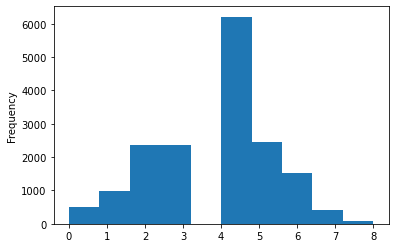

In [40]:
ros = RandomOverSampler(random_state=0, shrinkage=0.4)
x_resampled, y_resampled = ros.fit_resample(tfidf,y)
x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, train_size=0.8, random_state=0)
y.plot.hist()

## Feature selection
Feature selection allows automatic or manual selection of the features that contribute the most to the model.

An estimator is required for feature selection, where the estimator model must have a feature_importances_ or coef_ return attribute after fitting the model. The estimator calculates the feature importance and then SelectFromModel() will be used to disgard the features that are below a pre-set threshold. Features that are above or equal to the set threshold will be kept whereas the features below the set threshold will be disgarded.


In [41]:
lsvc = LinearSVC(penalty="l1", dual=False).fit(x_train, y_train)

In [42]:
threshold = 0.7

feature_names = np.array(x_train.columns)
sfm = SelectFromModel(lsvc, threshold=threshold).fit(x_train, y_train)

print("Features selected by SelectFromModel: "
      f"{feature_names[sfm.get_support()]}")

Features selected by SelectFromModel: ['00' '000' '00pm' ... 'zelin' 'zero' 'zeros']


In [43]:
new_features = feature_names[sfm.get_support()]
len(new_features)

4183

In [44]:
x = x_train[new_features]
x_train, x_test, y_train, y_test = train_test_split(x,y_train,random_state=0, train_size=0.8)

In [45]:
rf = RandomForestClassifier(random_state=0)
rf.fit(x_train,y_train)

RandomForestClassifier(random_state=0)

In [46]:
pred = rf.predict(x_test)

In [47]:
f1_score(y_test, pred, average="weighted") #Shrinkage = 0.4, 0.8129 f1 score, threshold = 0.4

0.8120348091934937

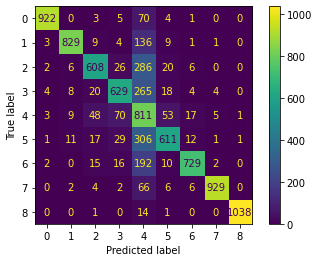

In [48]:
plot_confusion_matrix(rf, x_test, y_test);

In [49]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.98      0.92      0.95      1005
           1       0.96      0.84      0.89       992
           2       0.84      0.64      0.72       954
           3       0.81      0.66      0.73       952
           4       0.38      0.80      0.51      1017
           5       0.83      0.62      0.71       989
           6       0.94      0.75      0.84       966
           7       0.99      0.92      0.95      1015
           8       1.00      0.98      0.99      1054

    accuracy                           0.79      8944
   macro avg       0.86      0.79      0.81      8944
weighted avg       0.86      0.79      0.81      8944

